In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install bagpy --quiet

import os
import gc
import ast
import math
import h5py
import yaml
import time
import torch
import bagpy
import rosbag
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from bagpy import bagreader

%matplotlib inline
gc.collect()

SRC = "/content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/"
SRC_ESIM = "/content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/esim/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def unzip_npz(src):
  data = np.load(src, allow_pickle = True)
  lst = data.files
  for item in lst:
    print(item)
    #print(data[item])

def unzip(src, dest):
  t_file = tarfile.open(src) # Open file
  t_file.extractall(dest) # Extract file  
  t_file.close()

def parse_events(event):
  x = []
  y = []
  secs = []
  nsecs = []
  polarity = []
  tokens = event.splitlines();
  for t in tokens:
    if 'x: ' in t:
      temp_t = t
      if '[' in t: # Handle special case for beginning of array
        temp_t = temp_t.replace('[', '')
      elif 'polarity: False, ' in temp_t:
        temp_t = temp_t.replace('polarity: False, ', '') # Handle special case for polarity and x values being on same line
      elif 'polarity: True, ' in temp_t:
        temp_t = temp_t.replace('polarity: True, ', '')
      temp_t = temp_t.replace('x: ', '')
      x.append(int(temp_t))
    elif 'y: ' in t and t[0] == 'y': # Do not get lines with polarity, only y
      temp_t = t
      temp_t = temp_t.replace('y: ', '')
      y.append(int(temp_t))
    elif 'secs: ' in t and 'n' not in t:
      temp_t = t
      temp_t = temp_t.replace('secs: ', '')
      secs.append(int(temp_t))
    elif 'nsecs: ' in t:
      temp_t = t
      temp_t = temp_t.replace('nsecs: ', '')
      nsecs.append(int(temp_t))
    elif 'polarity: ' in t:
      temp_t = t
      if 'True' in temp_t:
        polarity.append(True)
      elif 'False' in temp_t:
        polarity.append(False)    
  return x, y, secs, nsecs, polarity

def unpack_rosbag(rosbag_path, topic_type):
  bag_reader_obj = bagreader(rosbag_path)
  # Output the topic table for reference
  print(bag_reader_obj.topic_table)
  # Decode messages by topic - run if you do not have the csv files saved already
  print("Creating .csv file.")
  topic = bag_reader_obj.message_by_topic(topic_type)
  print("File saved: {}".format(topic))
  # Create dataframe from the topic
  df = pd.read_csv(topic)
  return topic, df

def convert_rosbag_timestamps(df, time_series, ns_time_series):
  new_times = []
  init_t = df['header.stamp.secs'][0]
  init_ns = df['header.stamp.nsecs'][0]
  for time_, time_ns in zip(time_series, ns_time_series):
    new_time = (time_ - init_t) + ((time_ns - init_ns) / 1e9)
    new_times.append(new_time)
  # Append the series to the dataframe
  df['New Time'] = np.array(new_times).tolist()

def create_velocity_gt(df):
  ptr = 0
  time = []
  x = []
  y = []
  z = []
  while ptr < len(df) - 1:
    delta_time = df['New Time'][ptr + 1] - df['New Time'][ptr]
    timestamp = (df['New Time'][ptr + 1] + df['New Time'][ptr]) / 2
    time.append(timestamp)
    delta_x = df['transform.translation.x'][ptr + 1] - df['transform.translation.x'][ptr]
    delta_y = df['transform.translation.y'][ptr + 1] - df['transform.translation.y'][ptr]
    delta_z = df['transform.translation.z'][ptr + 1] - df['transform.translation.z'][ptr]
    result = calculate_velocity(delta_time, delta_x, delta_y, delta_z)
    x.append(result[0])
    y.append(result[1])
    z.append(result[2])
    ptr += 1
  d = {'Time': time, 'Vel_x': x, 'Vel_y': y, 'Vel_z': z}
  gt_df = pd.DataFrame.from_dict(d)
  return gt_df

def calculate_velocity(delta_time, delta_x, delta_y, delta_z):
  result = []
  x_component = (delta_x / delta_time)
  y_component = (delta_y / delta_time)
  z_component = (delta_z / delta_time)
  result.append(x_component)
  result.append(y_component)
  result.append(z_component)
  return result

def remove_rows_with_empty_events(csv_file):
  df = pd.read_csv(csv_file, index_col = 0)
  print("Length of original dataframe: ", len(df))
  temp_df = df.dropna(how = 'any')
  print("Length of dataframe after dropping NA values: ", len(temp_df))
  # Drop the time and other extra columns column
  temp_df = temp_df.drop('Time', axis = 1)
  # Drop the row if there are no events - convert string representation to list
  for index, e in temp_df.iterrows():
    list_rep_e = convert_to_list(e['Events']) # Event data here in tuple
    if len(list_rep_e) < 1:
      temp_df.drop(index, inplace = True) # Drop by index
  print("Length of dataframe after dropping empty events: ", len(temp_df))
  print("Shape of new dataframe: ", temp_df.shape)
  return temp_df.reset_index()

def convert_to_list(string_representation):
  list_ = ast.literal_eval(string_representation)
  return list_

def populate_gt_df(gt_df, event_df, start_flag):
  ptr = 0
  event_array_to_add = []
  while ptr < len(gt_df) - 1:
    if start_flag:
      if ptr == 0:
        events = align_events_with_gt(event_df, 0.0, gt_df['Time'][ptr])
      else:
        events = align_events_with_gt(event_df, gt_df['Time'][ptr], gt_df['Time'][ptr + 1])
    else:
      events = align_events_with_gt(event_df, gt_df['Time'][ptr], gt_df['Time'][ptr + 1])
    event_array_to_add.append(events) # List of group of events, or list of lists of lists
    print("Processed event group " + str(ptr) + " / " + str(len(gt_df)) + ".")
    ptr += 1
  # Concatenate to ground truth dataframe
  gt_df['Events'] = pd.Series(event_array_to_add)
  return gt_df

def align_events_with_gt(event_df, start_time, end_time):
  event_arrays = []
  event_group = event_df.loc[event_df['t'].between(start_time, end_time)]
  for e in tqdm(event_group.iterrows()): # e is a tuple
    event = [] # Represents a single event, list of t, x, y, p
    event.append(e[1][0]) # t
    event.append(e[1][1]) # x
    event.append(e[1][2]) # y
    event.append(e[1][3]) # p
    event_arrays.append(event) # All events within this time range, list of lists
  return event_arrays

In [ ]:
topic_sliding, df_sliding = unpack_rosbag(SRC + '2022-03-11-14-02-28_box_floor.bag', '/vicon/box/box')
convert_rosbag_timestamps(df_sliding, df_sliding['header.stamp.secs'], df_sliding["header.stamp.nsecs"])
df_sliding.head()

[INFO]  Successfully created the data folder /content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/2022-03-11-14-02-28_box_floor.
           Topics                            Types  Message Count    Frequency
0    /diagnostics  diagnostic_msgs/DiagnosticArray            107     0.984022
1         /rosout                rosgraph_msgs/Log              8  1985.939394
2     /rosout_agg                rosgraph_msgs/Log              2     0.600068
3             /tf               tf2_msgs/TFMessage           6458    59.792211
4  /vicon/box/box   geometry_msgs/TransformStamped           6238    59.799031
5  /vicon/markers             vicon_bridge/Markers           6457    59.789654
Creating .csv file.
File saved: /content/drive/Shareddrives/Shilpa_Thesis/3_11_2022/2022-03-11-14-02-28_box_floor/vicon-box-box.csv


,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,child_frame_id,transform.translation.x,transform.translation.y,transform.translation.z,transform.rotation.x,transform.rotation.y,transform.rotation.z,transform.rotation.w,New Time
0,1.647025e+09,38296,1647025348,730186569,/vicon/world,vicon/box/box,0.354663,0.462745,0.091698,0.009525,0.005766,0.972634,0.232074,0.000000
1,1.647025e+09,38297,1647025348,746947332,/vicon/world,vicon/box/box,0.354676,0.462746,0.091630,0.009436,0.005692,0.972620,0.232142,0.016761
2,1.647025e+09,38298,1647025348,763498506,/vicon/world,vicon/box/box,0.354672,0.462749,0.091686,0.009507,0.005739,0.972637,0.232063,0.033312
3,1.647025e+09,38299,1647025348,780239063,/vicon/world,vicon/box/box,0.354669,0.462745,0.091635,0.009465,0.005667,0.972618,0.232147,0.050052
4,1.647025e+09,38300,1647025348,796857081,/vicon/world,vicon/box/box,0.354668,0.462749,0.091697,0.009538,0.005770,0.972634,0.232073,0.066671


In [ ]:
df_sliding_mod = df_sliding[df_sliding['New Time'].between(12, 48)]

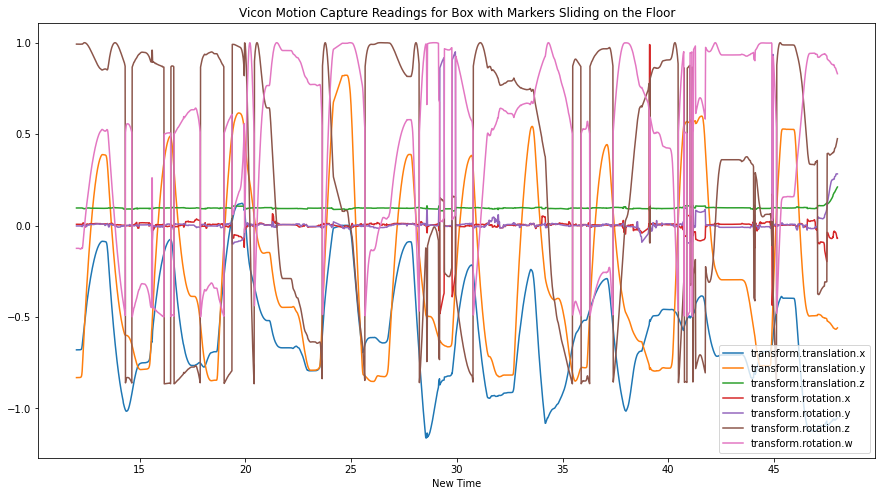

In [ ]:
df_sliding_mod.plot(x = 'New Time', 
                  y = ['transform.translation.x',
                       'transform.translation.y',
                       'transform.translation.z',
                       'transform.rotation.x',
                       'transform.rotation.y',
                       'transform.rotation.z',
                       'transform.rotation.w'], 
               title = 'Vicon Motion Capture Readings for Box with Markers Sliding on the Floor',
               figsize = (15, 8))

In [ ]:
df_sliding_mod = df_sliding_mod.reset_index(drop = True)
gt_sliding = create_velocity_gt(df_sliding_mod)
gt_sliding.head()

,Time,Vel_x,Vel_y,Vel_z
0,12.024709,0.000651,0.001147,0.005629
1,12.041345,-0.000780,-0.000743,-0.004968
2,12.058058,0.000424,0.000512,0.005870
3,12.074762,-0.000791,-0.001120,-0.007484
4,12.091423,0.000872,-0.000157,0.006826


In [ ]:
event_sliding_df = pd.read_csv(SRC + 'out.txt', sep = " ", skiprows = 1, index_col = False, names = ['t', 'x', 'y', 'p'])

In [ ]:
event_sliding_df['t'] = event_sliding_df['t'] + 12
event_sliding_df.head()

,t,x,y,p
0,12.033219,86,38,1
1,12.033234,109,81,1
2,12.095998,88,23,1
3,12.098062,83,19,1
4,12.193859,117,105,1


In [ ]:
gt_sliding_with_events = populate_gt_df(gt_sliding, event_sliding_df, False)
gt_sliding_with_events.head()

In [ ]:
gt_sliding_with_events.tail()

In [ ]:
gt_sliding_with_events.to_csv("/content/drive/Shareddrives/Shilpa_Thesis/processed_data/GT_FLOOR.csv")